In [30]:
%matplotlib inline
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We provide you with a class that can load the *hotdog/not hotdog* dataset you should use

In [31]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/scratch/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        #for img in self.image_paths:
        #    print((os.path.split(img)))
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        # fetch folder name as the class type
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something else than $128\times128$ images.

**TODO lists:** add by xiaohu
    1. what is the proper size for this specific task?
    2. data augmentation.
    3. modify batchSize, 64-default, 100?
    4. input normalization.

In [32]:
# TODO-1,2: what is the proper size for this specific task?
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

# TODO-3: what is the proper batchSize? 100
batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

torch.Size([64])


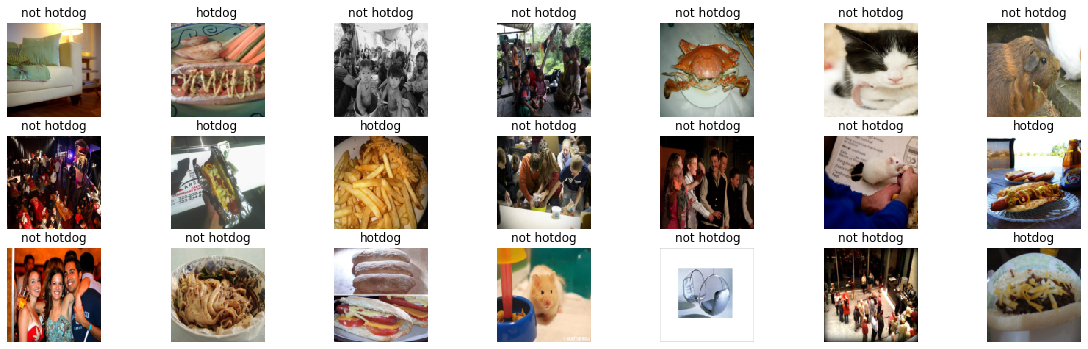

In [33]:
images, labels = next(iter(train_loader))
print(labels.shape)
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

CNN design: by xiaohu
1. try a net like VGG;
2. try ResNet;

TODO:
1. add batchNormalization;
2. SGD, SGD+Momentum, ~~Adam~~;
3. early stopping;

In [39]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        #...
        self.convolutional = nn.Sequential(
            ## input is 3x128x128
            # layer-1, 64x3x128x128
            nn.Conv2d(3,64,3,stride=1,padding=(1,1)),
            nn.ReLU(),
            # layer-2, 64x64x128x128
            nn.Conv2d(64,64,3,stride=1,padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # pooling, 64x64x64
            nn.MaxPool2d(2,stride=2),
            # layer-3, 128x64x64x64
            nn.Conv2d(64,128,3,stride=1,padding=(1,1)),
            nn.ReLU(),
            # layer-4, 128x128x64x64
            nn.Conv2d(128,128,3,stride=1,padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # pooling, 128x32x32
            nn.MaxPool2d(2,stride=2),
            # layer-5, 256x128x32x32
            nn.Conv2d(128,256,3,stride=1,padding=(1,1)),
            nn.ReLU(),
            # layer-6, 256x256x32x32
            nn.Conv2d(256,256,3,stride=1,padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # pooling, 256x16x16
            nn.MaxPool2d(2,stride=2),
            # layer-7, 512x16x16
            nn.Conv2d(256,512,3,stride=1,padding=(1,1)),
            nn.ReLU(),
            # layer-8, 512x16x16
            nn.Conv2d(512,512,3,stride=1,padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # pooling, 512x8x8
            nn.MaxPool2d(2,stride=2),
            # layer-9, 512x8x8
            nn.Conv2d(512,512,3,stride=1,padding=(1,1)),
            nn.ReLU(),
            # layer-10, 512x8x8
            nn.Conv2d(512,512,3,stride=1,padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # pooling, 512x4x4
            nn.MaxPool2d(2,stride=2)
        )
        
        self.fully_connected = nn.Sequential(
                nn.Linear(512*4*4, 4096),
                nn.ReLU(),
                nn.Linear(4096, 1000),
                nn.ReLU(),
                nn.Linear(1000,2),
                nn.Softmax(dim=1))
    def forward(self, x):
        # ...
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        
        return x

training part

In [40]:
model = Network()
print(model)

# check if GPU exsit
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

#Initialize the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Network(
  (convolutional): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [41]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    train_acc_all = []
    test_acc_all = []

    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = F.nll_loss(torch.log(output), target)## what does nll_loss mean
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data = data.to(device)
            with torch.no_grad():
                output = model(data)
            predicted = output.argmax(1).cpu()
            test_correct += (target==predicted).sum().cpu().item()
        train_acc = train_correct/len(trainset)
        test_acc = test_correct/len(testset)
        train_acc_all.append(train_acc)
        test_acc_all.append(test_acc)
        print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
    return test_acc_all, train_acc_all

In [42]:
test_acc, train_acc = train(model, optimizer, 50)# training

Accuracy train: 56.1%	 test: 53.4%


Accuracy train: 71.6%	 test: 75.2%


Accuracy train: 77.0%	 test: 68.1%


Accuracy train: 78.7%	 test: 56.4%


Accuracy train: 79.9%	 test: 53.9%


Accuracy train: 80.1%	 test: 71.5%


Accuracy train: 80.4%	 test: 66.4%


Accuracy train: 81.5%	 test: 60.8%


Accuracy train: 81.4%	 test: 78.8%


Accuracy train: 82.8%	 test: 74.8%


Accuracy train: 82.7%	 test: 76.7%


Accuracy train: 82.7%	 test: 78.0%


Accuracy train: 84.6%	 test: 77.0%


Accuracy train: 84.0%	 test: 79.4%


Accuracy train: 85.1%	 test: 78.0%


Accuracy train: 86.6%	 test: 75.7%


Accuracy train: 85.9%	 test: 73.9%


Accuracy train: 86.3%	 test: 78.4%


Accuracy train: 87.1%	 test: 80.6%


Accuracy train: 87.3%	 test: 66.6%


Accuracy train: 89.2%	 test: 79.6%


Accuracy train: 89.0%	 test: 79.8%


Accuracy train: 88.2%	 test: 80.3%


Accuracy train: 89.6%	 test: 79.5%


Accuracy train: 91.2%	 test: 79.3%


Accuracy train: 90.4%	 test: 79.2%


Accuracy train: 91.5%	 test: 79.7%


Accuracy train: 92.0%	 test: 77.9%


Accuracy train: 92.5%	 test: 81.3%


Accuracy train: 91.9%	 test: 80.2%


Accuracy train: 93.9%	 test: 81.0%


Accuracy train: 94.7%	 test: 78.1%


Accuracy train: 92.2%	 test: 78.4%


Accuracy train: 94.4%	 test: 78.3%


Accuracy train: 94.3%	 test: 76.9%


Accuracy train: 96.5%	 test: 79.1%


Accuracy train: 96.4%	 test: 80.1%


Accuracy train: 96.7%	 test: 76.7%


Accuracy train: 96.0%	 test: 69.7%


Accuracy train: 97.1%	 test: 79.4%


Accuracy train: 97.2%	 test: 77.8%


Accuracy train: 98.2%	 test: 77.3%


Accuracy train: 98.8%	 test: 78.7%


Accuracy train: 98.9%	 test: 79.4%


Accuracy train: 97.4%	 test: 78.4%


Accuracy train: 96.7%	 test: 78.0%


Accuracy train: 98.9%	 test: 78.4%


Accuracy train: 99.3%	 test: 78.1%


Accuracy train: 99.5%	 test: 79.8%


Accuracy train: 99.8%	 test: 78.4%



Text(0, 0.5, 'Accuracy')

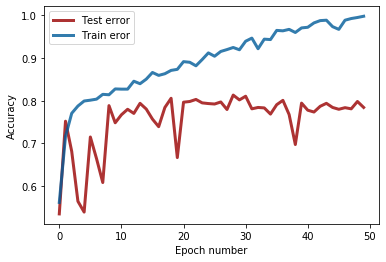

In [43]:
plt.plot(test_acc,c='#990000',alpha=0.8,linewidth=3,label='test_acc')
plt.plot(train_acc,c='#005b99',alpha=0.8,linewidth=3,label='train_acc')
# ...
plt.legend(('Test error','Train eror'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

In [47]:
torch.save(model, './model/vgg-like-hotdog.tar')# save this model

/home/xiahaa/.conda/envs/py3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [48]:
# test model
trained_model = torch.load('./model/vgg-like-hotdog.tar')

test_correct = 0
trained_model.eval()
for data, target in test_loader:
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().cpu().item()
test_acc = test_correct/len(testset)
print('Test Accuracy:%s'%test_acc)

Test Accuracy:0.7841031149301826


ok, the first model achieves 78.4% accuracy. From the loss curve, it seems the model is over-fitted. the maximum accuracy could be 81%.